[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alvaro-francisco-gil/nn4nlp/blob/main/exercises/practica1_francisco_gil_alvaro.ipynb)


This practice is similar to the previous one until the encoding part.

[Jump to Encoding](#Encoding)

In [1]:
import re
import string
from collections import Counter
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
print(torch.cuda.is_available())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True


# Analyze Data

In [2]:
train_file = '/root/nn4nlp/data/train_reviews.csv'
df = pd.read_csv(train_file)
df.head()

,id,review,sentiment
0,17527,People tried to make me believe that the premi...,negative
1,24155,I have been wanting to see cut since the day i...,positive
2,21972,This movie is terrible. The suspense is spent ...,negative
3,4565,I hope she can keep acting and directing. She'...,positive
4,22098,I fell in love with this silent action drama. ...,positive


In [3]:
df.shape

(8000, 3)

In [4]:
test_file = '/root/nn4nlp/data/test_reviews.csv'
test_df = pd.read_csv(test_file)
test_df.head()

,id,review,sentiment
0,6666,Movies about dinosaurs can be entertaining. So...,negative
1,23267,If it's action and adventure you want in a mov...,positive
2,2897,Barbra Streisand is a tour de force in this Ho...,positive
3,23177,I borrowed this movie despite its extremely lo...,positive
4,14171,"""Baby Face"" is a precode melodrama starring a ...",positive


In [5]:
test_df.shape

(2000, 3)

## Check class balance

In [6]:
df.value_counts('sentiment')

sentiment
positive    4012
negative    3988
Name: count, dtype: int64

In [7]:
test_df.value_counts('sentiment')

sentiment
negative    1025
positive     975
Name: count, dtype: int64

Both classes are balanced

## Check missing values

In [8]:
df.isna().sum()


id           0
review       0
sentiment    0
dtype: int64

In [9]:
test_df.isna().sum()

id           0
review       0
sentiment    0
dtype: int64

## Visual Inspection

In [10]:
df.iloc[1]['review']

"I have been wanting to see cut since the day i have heard of it, which was sometime last year. Anyway i got to see today, and when the movie started i thought that it started rather week but it got better after 10 mins or so. I thought that the movie was pretty good. but the thing i didn't like was how the killer was created, i was thinking just before i rented that it would probably suck just like Urban legends: final cut, i almost died it. mostly everything in UL final cut needed to be improved. CUT is 100 times better than UL:final cut. The best part of CUT is the killer and the death scenes. The killer kicks MO F***ING ASS.<br /><br />i give cut a 8 out of 10"

In [11]:
df.iloc[2]['review']

'This movie is terrible. The suspense is spent waiting for a point. There isn\'t much of one.<br /><br />Aside from a few great lines ( "I found a tooth in my apartment" ), and the main characters dedication to killing himself, it\'s a collection of supposedly eerie sounds.<br /><br />'

Insigths:
- Needd to remove HTML labels
- Not in lowercase

## Word Histogram

In [12]:
def plot_word_histogram(text_array):
    # Convert input to a flat list of strings
    if isinstance(text_array, str):
        # If it's a single string, convert to list
        text_array = [text_array]
    elif isinstance(text_array, list):
        # Flatten nested lists and ensure all elements are strings
        flattened = []
        for item in text_array:
            if isinstance(item, list):
                flattened.extend(item)
            else:
                flattened.append(item)
        text_array = [str(item) for item in flattened]
    else:
        raise ValueError("Input must be a string or a list of strings.")

    # Join all text into one string
    all_text = ' '.join(text_array)

    # Tokenize words by splitting on whitespace
    words = all_text.split()

    # Count word frequencies
    word_counts = Counter(words)
    labels, values = zip(*word_counts.items())

    # Sort by frequency in descending order
    sorted_indices = np.argsort(values)[::-1]
    labels = np.array(labels)[sorted_indices]
    values = np.array(values)[sorted_indices]

    # Plot the histogram for the top 10 most frequent words
    plt.figure(figsize=(10, 6))
    plt.bar(labels[:10], values[:10], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

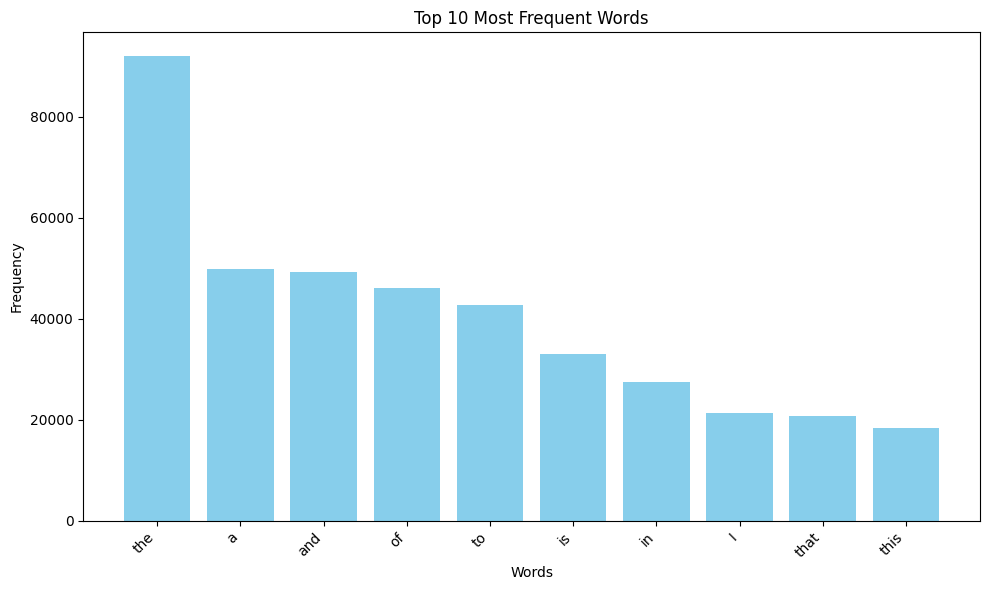

In [13]:
plot_word_histogram(df['review'].to_list())

# Pre-processing

In [14]:
data = np.concatenate([df['review'].values,test_df['review'].values],axis=0)
raw_data = data
data.shape

(10000,)

## Remove HTML labels

In [15]:
def clean_htmls_text_array(text_array):

    def remove_html_tags(text):
        pattern = re.compile('<.*?>')
        clean_text = re.sub(pattern, '', text)
        clean_text = ' '.join(clean_text.split())
        return clean_text

    cleaned_array = [remove_html_tags(text) for text in text_array]

    return cleaned_array

In [16]:
data[1][-40:]

'ASS.<br /><br />i give cut a 8 out of 10'

In [17]:
data = clean_htmls_text_array(data)

In [18]:
data[1][-40:]

' MO F***ING ASS.i give cut a 8 out of 10'

## Downcase

In [19]:
def lowercase_array(text_array):
    return [text.lower() for text in text_array]

In [20]:
data = lowercase_array(data)

In [21]:
data[1][-40:]

' mo f***ing ass.i give cut a 8 out of 10'

I don't want to remove the numbers as they may contain valuable information for the classifier, as in this case: "8 out of 10"

I test the hypothesis:

In [22]:
def find_term_with_context(text_array, term, context_chars=5):
    occurrences = 0
    occurrences_list = []

    for text in text_array:
        start = 0
        while (start := text.find(term, start)) != -1:
            occurrences += 1
            context_start = max(0, start - context_chars)
            context_end = min(len(text), start + len(term) + context_chars)
            context = text[context_start:context_end]

            occurrences_list.append(f"...{context}...")
            start += len(term)

    print(f"\nTotal occurrences of '{term}': {occurrences}")
    return occurrences, occurrences_list

In [23]:
_,ocurrences = find_term_with_context(data, 'out of')
ocurrences[1]


Total occurrences of 'out of': 2070


'... a 3 out of 10, ...'

We see that 2070 reviews contain a possible explicit grade

## Expand Contractions

In [24]:
def expand_contractions(texts):
    contractions = {
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'ve": " have",
        "'m": " am"
    }
    def expand(text):
        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)
        return text
    return [expand(text) for text in texts]

In [25]:
data[0][330:380]

"a never-ending murder spree. it's not a highly ori"

In [26]:
data = expand_contractions(data)

In [27]:
data[0][330:380]

'a never-ending murder spree. it is not a highly or'

## Remove Punctuation

In [28]:
def remove_punctuation(texts):
    translator = str.maketrans('', '', string.punctuation)
    return [text.translate(translator) for text in texts]

In [29]:
data = remove_punctuation(data)

In [30]:
data[0][330:380]

'erending murder spree it is not a highly original '

## Tokenization

In [31]:
def tokenize_texts(texts):
    return [word_tokenize(text) for text in texts]

In [32]:
data = tokenize_texts(data)

In [33]:
data[0][:5]

['people', 'tried', 'to', 'make', 'me']

## Lemmatization

In [34]:
def lemmatize_texts(tokenized_texts):
    lemmatizer = WordNetLemmatizer()
    return [[lemmatizer.lemmatize(word) for word in text] for text in tokenized_texts]

In [35]:
data[0][29]

'escapes'

In [36]:
data = lemmatize_texts(data)

In [37]:
data[0][29]

'escape'

## Stopword Removal

In [38]:
def remove_stopwords(tokenized_texts):
    stop_words = set(stopwords.words('english'))
    return [[word for word in text if word.lower() not in stop_words] for text in tokenized_texts]

In [39]:
data[0][:7]

['people', 'tried', 'to', 'make', 'me', 'believe', 'that']

In [40]:
data = remove_stopwords(data)

In [41]:
data[0][:7]

['people', 'tried', 'make', 'believe', 'premise', 'rubbishy', 'supernatural']

## Preprocessing Function

The lemmatization is not needed as for word2vec it is better to keep the original words

In [42]:
def preprocess_data(data):
    data = clean_htmls_text_array(data)
    data = lowercase_array(data)
    data = expand_contractions(data)
    data = remove_punctuation(data)
    data = tokenize_texts(data)
    # data = lemmatize_texts(data)
    data = remove_stopwords(data)
    return data

In [43]:
processed_data = preprocess_data(raw_data)

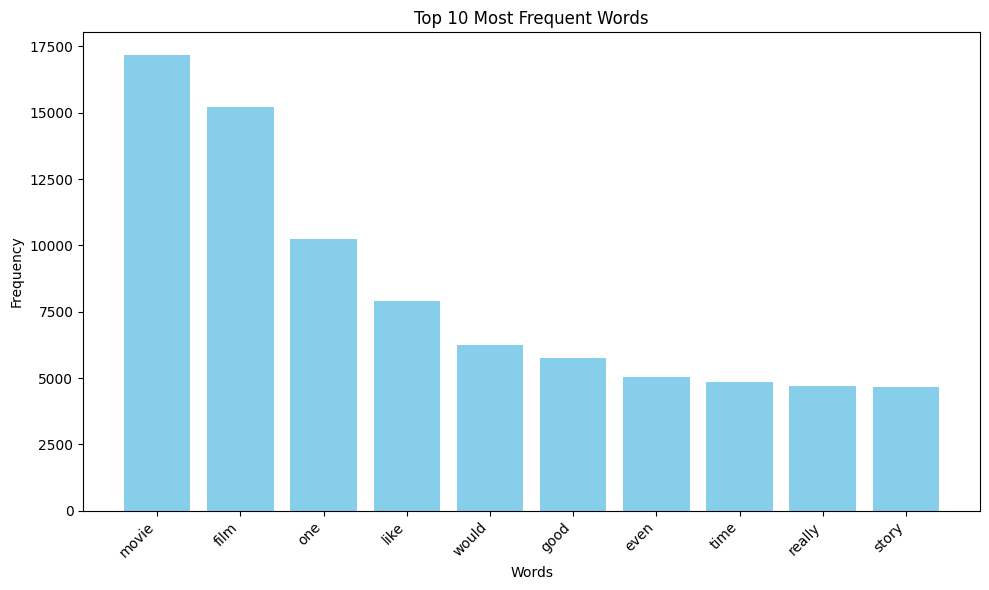

In [44]:
plot_word_histogram(processed_data)

# Encoding

There is a decision to be made here on the encoding scheme. I will use Word2Vec instead of TF-IDF or Bag-of-Words (BoW) because it produces smaller output dimensions, and I believe it could be interesting to aggregate the word embeddings rather than using simpler aggregation methods.

In [45]:
combined_sentiments = np.concatenate([df['sentiment'].values, test_df['sentiment'].values])
combined_sentiments.shape

(10000,)

The added parameter aggregate is used to decide if the word embeddings should be aggregated or not.

In [46]:
def encode_word2vec(data: List[List[str]], labels: List[str], train_size: int = 8000, aggregate: bool = True, dimensions_word2vec: int = 100) -> Tuple:
    # Encode the sentiment labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)

    # Split the data
    X_train = data[:train_size]
    X_test = data[train_size:]
    y_train = y_encoded[:train_size]
    y_test = y_encoded[train_size:]

    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=data, vector_size=dimensions_word2vec, window=5, min_count=1, workers=4)

    if aggregate:
        # Create document embeddings by averaging word vectors
        def document_vector(doc):
            word_vectors = [w2v_model.wv[word] for word in doc if word in w2v_model.wv]
            return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(100)

        X_train_w2v = np.array([document_vector(doc) for doc in X_train])
        X_test_w2v = np.array([document_vector(doc) for doc in X_test])
    
    else:
        # Return word-level embeddings for each document
        def word_vectors_for_document(doc):
            return np.array([w2v_model.wv[word] for word in doc if word in w2v_model.wv])

        X_train_w2v = [word_vectors_for_document(doc) for doc in X_train]
        X_test_w2v = [word_vectors_for_document(doc) for doc in X_test]

    return (X_train_w2v, X_test_w2v, y_train, y_test)

In [47]:
X_train, X_test, y_train, y_test = encode_word2vec(data, combined_sentiments, aggregate=False)

# Concatenation and Padding

Let's visualize the sentence lengths to decide a padding length for the convolutions.

In [48]:
def plot_sentence_lengths(tokenized_texts, bins=50):
    # Calculate lengths of each text
    lengths = [len(text) for text in tokenized_texts]
    
    # Calculate quartiles
    q1, q2, q3 = np.percentile(lengths, [25, 50, 75])
    
    # Create the histogram
    plt.figure(figsize=(12, 6))
    plt.hist(lengths, bins=bins, color='skyblue', edgecolor='black')
    
    # Add labels and title
    plt.title('Histogram of Review Lengths (in words)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    
    # Add vertical lines for statistics
    plt.axvline(np.mean(lengths), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(lengths):.1f}')
    plt.axvline(q2, color='green', linestyle='dashed', linewidth=1, label=f'Median: {q2:.1f}')
    plt.axvline(q1, color='orange', linestyle='dashed', linewidth=1, label=f'Q1: {q1:.1f}')
    plt.axvline(q3, color='purple', linestyle='dashed', linewidth=1, label=f'Q3: {q3:.1f}')
    
    # Add statistics text box
    stats_text = (f'Mean: {np.mean(lengths):.1f}\n'
                 f'Q1: {q1:.1f}\n'
                 f'Median: {q2:.1f}\n'
                 f'Q3: {q3:.1f}\n'
                 f'IQR: {(q3-q1):.1f}\n'
                 f'Max: {np.max(lengths)}\n'
                 f'Min: {np.min(lengths)}')
    plt.text(0.95, 0.95, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.legend()
    plt.tight_layout()
    plt.show()

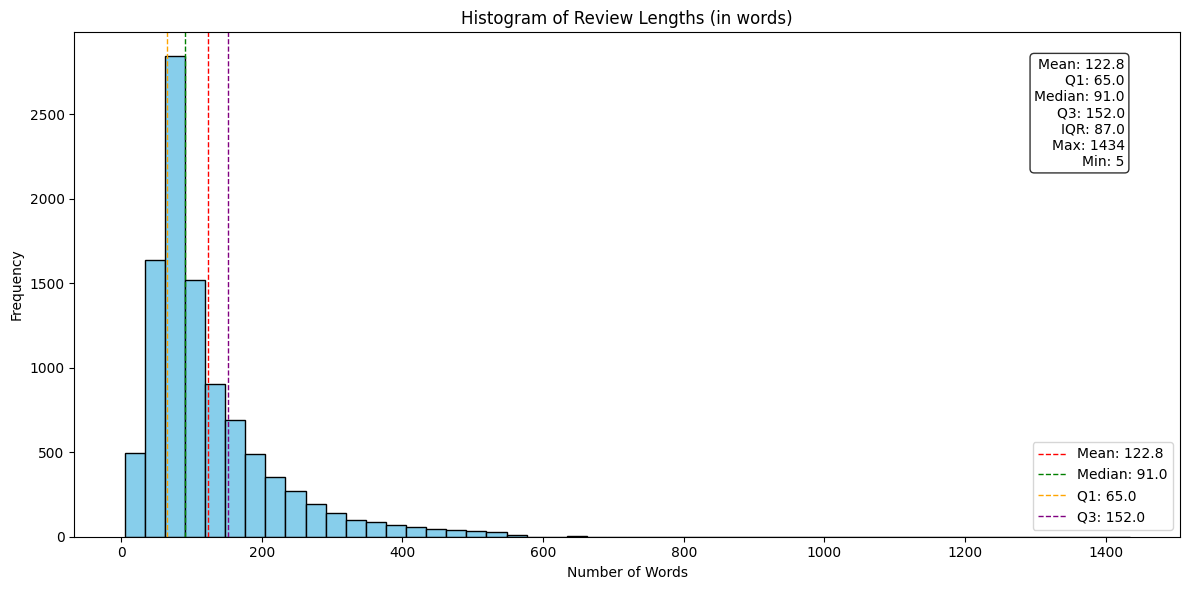

In [49]:
plot_sentence_lengths(data)

It could be interesting to use the Q3 as the padding length for the convolutions, which is 152.

In [50]:
def pad_sequences(sequences, padding_length):
    # Get the embedding dimension from the first sequence
    embedding_dim = sequences[0].shape[1]
    padded = np.zeros((len(sequences), padding_length, embedding_dim))
    
    for i, seq in enumerate(sequences):
        # Truncate if longer than padding_length
        length = min(len(seq), padding_length)
        padded[i, :length, :] = seq[:length]
        
    return padded

In [51]:
tokens_per_review = 152
X_train_padded = pad_sequences(X_train, tokens_per_review)
X_train_padded.shape

(8000, 152, 100)

In [52]:
X_test_padded = pad_sequences(X_test, 152)
X_test_padded.shape

(2000, 152, 100)

# Modelling

In [53]:
# Early stopping class to monitor validation loss and save best model
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None
        self.checkpoint_path = checkpoint_path
        
    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            torch.save(self.best_model_state, self.checkpoint_path)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            torch.save(self.best_model_state, self.checkpoint_path)
            self.counter = 0
            
    def load_best_model(self, model):
        model.load_state_dict(torch.load(self.checkpoint_path))
        return model

In [54]:
def train_model(model, X_train, y_train, X_test, y_test, num_epochs=10, batch_size=32, patience=5, verbose=False):
    # Initialize loss tracking
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test) 
    y_test_tensor = torch.FloatTensor(y_test)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Calculate training accuracy
            predicted = (outputs >= 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Evaluate on test set
        model.eval()
        total_test_loss = 0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                total_test_loss += loss.item()
                
                predicted = (outputs >= 0.5).float()
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
        
        # Calculate average losses and accuracies
        avg_train_loss = total_train_loss / len(train_loader)
        avg_test_loss = total_test_loss / len(test_loader)
        train_accuracy = 100 * train_correct / train_total
        test_accuracy = 100 * test_correct / test_total
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Training Loss: {avg_train_loss:.4f}')
            print(f'Test Loss: {avg_test_loss:.4f}')
            print(f'Training Accuracy: {train_accuracy:.2f}%')
            print(f'Test Accuracy: {test_accuracy:.2f}%')
            print('-' * 50)

        # Early stopping check
        early_stopping(model=model, val_loss=avg_test_loss)
        if early_stopping.early_stop:
            if verbose:
                print("Early stopping triggered")
            break

    # Plot training and test losses
    if verbose:
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss Over Time')
        plt.legend()
        plt.show()
    
    # Load the best model before returning and remove the checkpoint file
    model.load_state_dict(torch.load('checkpoint.pt'))
    os.remove('checkpoint.pt')
    
    return model, train_losses, test_losses, train_accuracies, test_accuracies

# SentimentCNN

The SentimentCNN class takes the following parameters:

- `input_channels` (default=100): The number of input channels, which corresponds to the dimensionality of word embeddings

- `conv_channels` (default=[64, 32]): A list specifying the number of output channels for each convolutional layer. In the default configuration, the first conv layer outputs 64 channels and the second outputs 32 channels.

- `kernel_sizes` (default=[3, 3]): A list specifying the size of convolutional kernels for each conv layer. The default uses 3x1 kernels for both layers.

- `pool_sizes` (default=[2, 2]): A list specifying the size of max pooling windows for each conv layer. The default uses 2x1 pooling windows.

- `fc_sizes` (default=[64]): A list specifying the number of neurons in each fully connected layer. The default has one hidden layer with 64 neurons.

- `dropout_rate` (default=0.5): The probability of dropping out neurons during training to prevent overfitting.

- `sequence_length` (default=152): The length of input sequences (padded/truncated review length).

The model architecture consists of:
1. Multiple convolutional layers with ReLU activation and max pooling
2. Fully connected layers with ReLU activation and dropout
3. A final output layer with sigmoid activation for binary classification


In [55]:
# Create a CNN model            
class SentimentCNN(nn.Module):
    def __init__(self, 
                 input_channels=100,
                 conv_channels=[64, 32], 
                 kernel_sizes=[3, 3],
                 pool_sizes=[2, 2], 
                 fc_sizes=[64],
                 dropout_rate=0.5,
                 sequence_length=152):
        super(SentimentCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.ModuleList()
        in_channels = input_channels
        
        for out_channels, kernel_size, pool_size in zip(conv_channels, kernel_sizes, pool_sizes):
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size),
                nn.ReLU(),
                nn.MaxPool1d(pool_size)
            )
            self.conv_layers.append(conv_block)
            in_channels = out_channels
            sequence_length = (sequence_length - kernel_size + 1) // pool_size
            
        # Calculate flattened features size
        self.flat_features = conv_channels[-1] * sequence_length
        
        # Dense layers
        self.fc_layers = nn.ModuleList()
        in_features = self.flat_features
        
        for out_features in fc_sizes:
            fc_block = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            self.fc_layers.append(fc_block)
            in_features = out_features
            
        # Output layer
        self.output_layer = nn.Sequential(
            nn.Linear(in_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Transpose input to match PyTorch's expected shape (batch, channels, length)
        x = x.transpose(1, 2)
        
        # Convolutional layers
        for conv_block in self.conv_layers:
            x = conv_block(x)
        
        # Flatten
        x = x.view(-1, self.flat_features)
        
        # Dense layers
        for fc_block in self.fc_layers:
            x = fc_block(x)
            
        # Output layer
        x = self.output_layer(x)
        
        return x

Epoch [1/10]
Training Loss: 0.5865
Test Loss: 0.4881
Training Accuracy: 68.53%
Test Accuracy: 77.10%
--------------------------------------------------
Epoch [2/10]
Training Loss: 0.4834
Test Loss: 0.4506
Training Accuracy: 77.19%
Test Accuracy: 79.10%
--------------------------------------------------
Epoch [3/10]
Training Loss: 0.4623
Test Loss: 0.4855
Training Accuracy: 78.25%
Test Accuracy: 77.80%
--------------------------------------------------
Epoch [4/10]
Training Loss: 0.4455
Test Loss: 0.4524
Training Accuracy: 79.14%
Test Accuracy: 79.50%
--------------------------------------------------
Epoch [5/10]
Training Loss: 0.4158
Test Loss: 0.4398
Training Accuracy: 81.62%
Test Accuracy: 79.80%
--------------------------------------------------
Epoch [6/10]
Training Loss: 0.3853
Test Loss: 0.4352
Training Accuracy: 82.95%
Test Accuracy: 80.05%
--------------------------------------------------
Epoch [7/10]
Training Loss: 0.3625
Test Loss: 0.4303
Training Accuracy: 84.46%
Test Accu

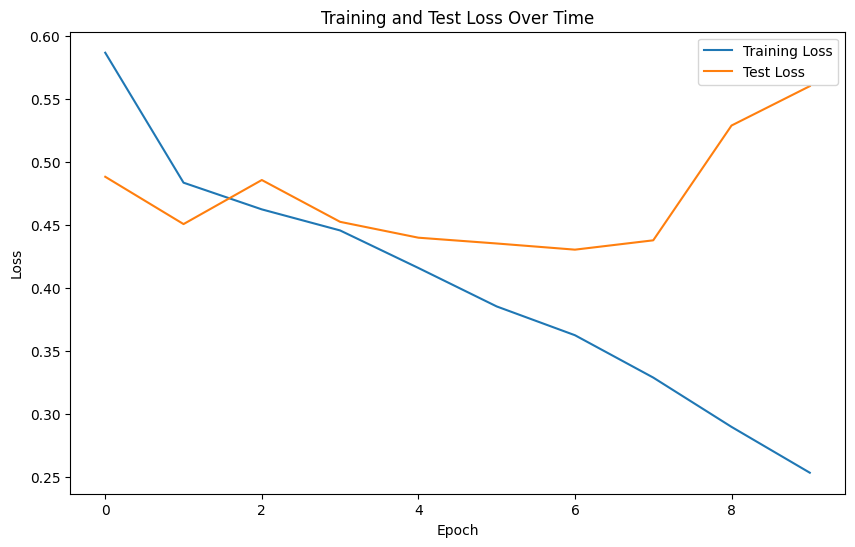

In [56]:
# Example
model = SentimentCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, X_train_padded, y_train, X_test_padded, y_test, num_epochs=10, verbose=True)

In [57]:
# Define parameter grid
PARAM_GRID = {
    'dimensions_word2vec': [100, 200, 300],
    'tokens_per_review': [150, 250, 500], 
    'conv_channels': [[32, 16], [64, 32]],
    'kernel_sizes': [[3, 3], [5, 3]],
    'pool_sizes': [[2, 2], [3, 2]],
    'fc_sizes': [[32], [64]],
    'dropout_rate': [0.3, 0.5]
}

In [58]:
def grid_search_sentiment_cnn(processed_data, combined_sentiments, num_epochs=10, patience=5):
    # Replace full param grid with test grid if specified
    param_grid = PARAM_GRID

    # Store results
    results = []
    best_model = None

    # Grid search
    for conv_channels in param_grid['conv_channels']:
        for kernel_sizes in param_grid['kernel_sizes']:
            for pool_sizes in param_grid['pool_sizes']:
                for fc_sizes in param_grid['fc_sizes']:
                    for dropout_rate in param_grid['dropout_rate']:
                        for dimensions_word2vec in param_grid['dimensions_word2vec']:
                            for tokens_per_review in param_grid['tokens_per_review']:

                                # Data
                                X_train, X_test, y_train, y_test = encode_word2vec(
                                    processed_data,
                                    combined_sentiments,
                                    train_size=8000,
                                    aggregate=False,
                                    dimensions_word2vec=dimensions_word2vec)
                                
                                X_train_padded = pad_sequences(X_train, tokens_per_review)
                                X_test_padded = pad_sequences(X_test, tokens_per_review)

                                # Initialize model with current parameters
                                model = SentimentCNN(
                                    input_channels=dimensions_word2vec,
                                    conv_channels=conv_channels,
                                    kernel_sizes=kernel_sizes,
                                    pool_sizes=pool_sizes,
                                    fc_sizes=fc_sizes,
                                    dropout_rate=dropout_rate,
                                    sequence_length=tokens_per_review
                                )
                                
                                criterion = nn.BCELoss()
                                optimizer = torch.optim.Adam(model.parameters())
                                
                                # Train model
                                model, train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                                    model, 
                                    X_train_padded, 
                                    y_train, 
                                    X_test_padded, 
                                    y_test, 
                                    num_epochs=num_epochs,
                                    patience=patience
                                )
                                
                                # Store results
                                result = {
                                    'conv_channels': conv_channels,
                                    'kernel_sizes': kernel_sizes,
                                    'pool_sizes': pool_sizes,
                                    'fc_sizes': fc_sizes,
                                    'dimensions_word2vec': dimensions_word2vec,
                                    'tokens_per_review': tokens_per_review,
                                    'dropout_rate': dropout_rate,
                                    'final_train_loss': min(train_losses),
                                    'final_test_loss': min(test_losses),
                                    'final_train_accuracy': max(train_accuracies),
                                    'final_test_accuracy': max(test_accuracies)
                                }
                                results.append(result)
                                
                                # Update best model if current is better
                                if not best_model or result['final_test_accuracy'] > best_result['final_test_accuracy']:
                                    best_model = model
                                    best_result = result

    # Find best model based on test accuracy
    best_result = max(results, key=lambda x: x['final_test_accuracy'])
    print("\nBest parameters:")
    print(f"Model parameters:")
    print(f"Conv channels: {best_result['conv_channels']}")
    print(f"Kernel sizes: {best_result['kernel_sizes']}")
    print(f"Pool sizes: {best_result['pool_sizes']}")
    print(f"FC sizes: {best_result['fc_sizes']}")
    print(f"Dropout rate: {best_result['dropout_rate']}")
    print(f"\nData parameters:")
    print(f"Word2Vec dimensions: {best_result['dimensions_word2vec']}")
    print(f"Tokens per review: {best_result['tokens_per_review']}")
    print(f"\nResults:")
    print(f"Test loss: {best_result['final_test_loss']:.4f}")
    print(f"Train accuracy: {best_result['final_train_accuracy']:.4f}")
    print(f"Test accuracy: {best_result['final_test_accuracy']:.4f}")

    # Return best model and parameters
    best_params = {
        'model_params': {
            'conv_channels': best_result['conv_channels'],
            'kernel_sizes': best_result['kernel_sizes'],
            'pool_sizes': best_result['pool_sizes'],
            'fc_sizes': best_result['fc_sizes'],
            'dropout_rate': best_result['dropout_rate']
        },
        'data_params': {
            'dimensions_word2vec': best_result['dimensions_word2vec'],
            'tokens_per_review': best_result['tokens_per_review']
        }
    }

    return best_model, best_params

In [59]:
best_model, best_params = grid_search_sentiment_cnn(processed_data, combined_sentiments, num_epochs=10, patience=5)

In [60]:
# Save best model and load it
torch.save(best_model, 'best_model.pt')
best_model = torch.load('best_model.pt')

# Mechanistic Interpretation